# Waste Classification Model

**Data source:** https://www.kaggle.com/techsash/waste-classification-data

In [37]:
# Dependencies

import pandas as pd
import numpy as np
import logging
import tensorflow as tf
import warnings
import glob
import tqdm
import os

from tqdm import tqdm 
from IPython import display 
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread, imshow
from skimage.transform import resize

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten # convolution layers & core layers

from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

warnings.filterwarnings("ignore")

## Data Structure
Data source: https://www.kaggle.com/techsash/waste-classification-data

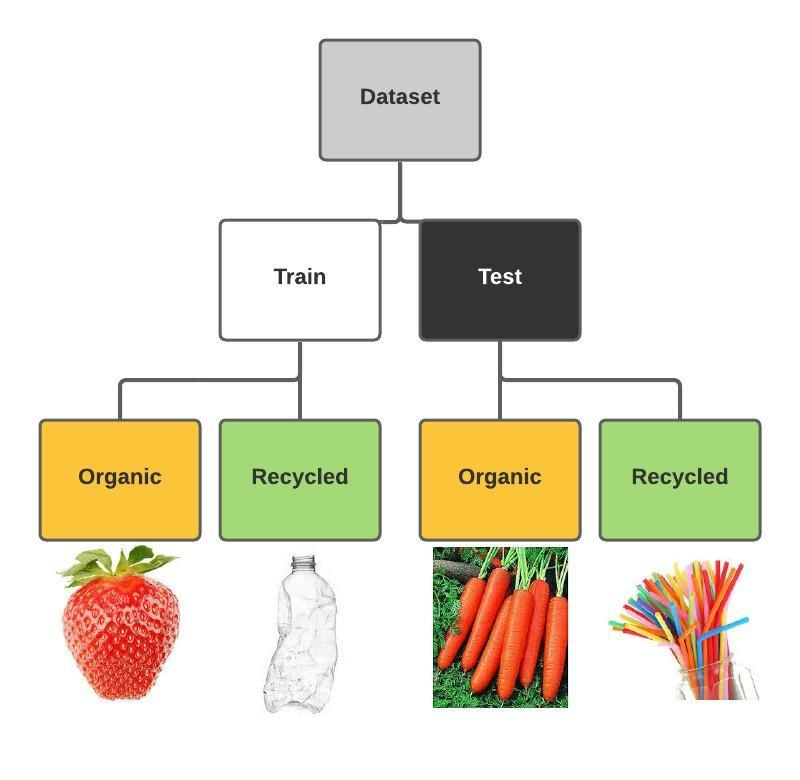

In [2]:
# Show the overall structure of the dataset
display.Image('Resources/Images/waste_data_structure.jpeg', width = 550, height = 250)

In [3]:
# Directory paths for importing data

base_dir = "Resources/Dataset"
train_dir = os.path.join(base_dir, "Train")
test_dir = os.path.join(base_dir, "Test")

In [4]:
# Os path join (train)

train_o = glob.glob(os.path.join(train_dir, 'O', '*.jpg'))
train_r = glob.glob(os.path.join(train_dir, 'R', '*.jpg'))

a = len(train_o)
b = len(train_r)

print("Number of training samples: {}".format(a+b))

Number of training samples: 22564


In [5]:
# Os path join (test)

test_o = glob.glob(os.path.join(test_dir, 'O', '*.jpg'))
test_r = glob.glob(os.path.join(test_dir, 'R', '*.jpg'))

a = len(test_o)
b = len(test_r)


print("Number of test samples: {}".format(a+b))

Number of test samples: 2513


## Data Augmentation

In [6]:
# Datagenerators

train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

## Train dataset

In [7]:
# Train dataset

train_ds  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (180, 180),
                                                   class_mode = 'categorical',
                                                   batch_size = 32, 
                                                   subset = 'training')

Found 18052 images belonging to 2 classes.


## Validate dataset

In [8]:
# Validate dataset

valid_ds = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = (180, 180),
                                                  class_mode = 'categorical',
                                                  batch_size = 32, 
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


## Test dataset

In [9]:
# Test dataset

test_ds = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (180, 180),
                                                  class_mode = 'categorical',
                                                  batch_size = 32,
                                                  shuffle=False)

Found 2513 images belonging to 2 classes.


In [10]:
# Check classes

print(train_ds.class_indices)
print(test_ds.class_indices)

{'O': 0, 'R': 1}
{'O': 0, 'R': 1}


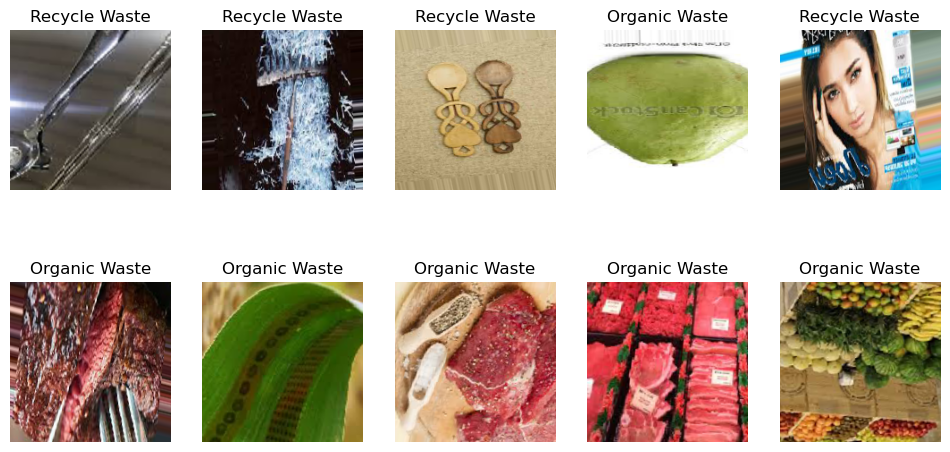

In [11]:
# Viewing images

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (12,6))
#plt.subplots_adjust(hspace=0.55)

for i in range(2):
    for j in range(5):
        rand1 = np.random.randint(len(train_ds))
        rand2 = np.random.randint(32)
        ax[i,j].imshow(train_ds[rand1][0][rand2])
        ax[i,j].axis('off')
        label = train_ds[rand1][1][rand2]
        # print(label[0])
        if label[0] == 0:
            ax[i,j].set_title('Recycle Waste')
        else:
            ax[i,j].set_title('Organic Waste')

plt.tight_layout
plt.show()

# Building The Model

In [18]:
# Defining callbacks

# filepath = './final_model_weights.hdf5'
filepath = 'final_model'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

## Base Model (VGG16)

In [19]:
# Base model

base_model = VGG16(input_shape=(180,180,3), 
                   include_top=False,
                   weights="imagenet")

In [20]:
# Freezing layers 

for layer in base_model.layers:
    layer.trainable=False

In [21]:
# Show vgg model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

## Visualizing Base Model Layers With Test Images

block1_conv1
64


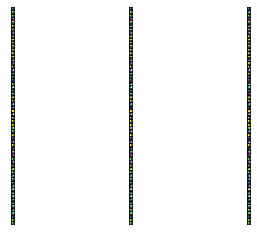

block1_conv2
64


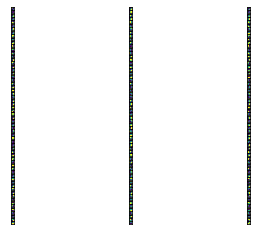

block2_conv1
128


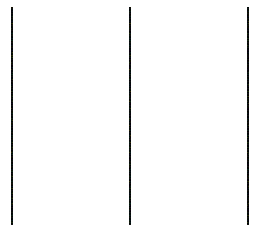

block2_conv2
128


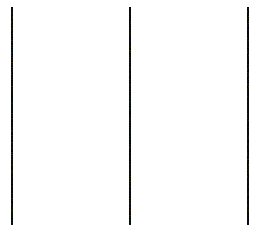

block3_conv1
256


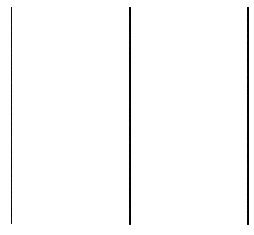

block3_conv2
256


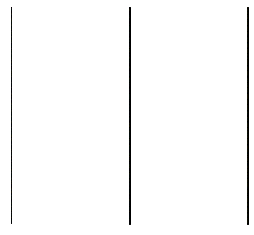

block3_conv3
256


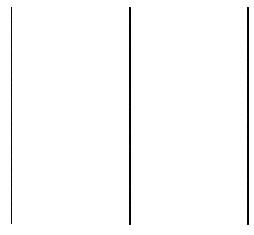

block4_conv1
512


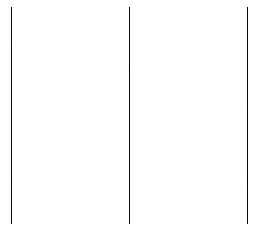

block4_conv2
512


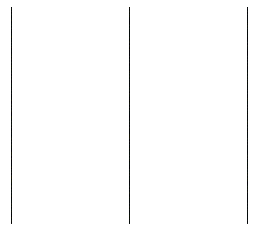

block4_conv3
512


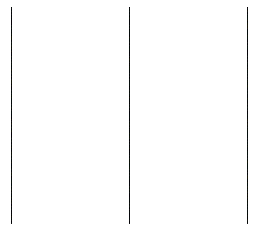

block5_conv1
512


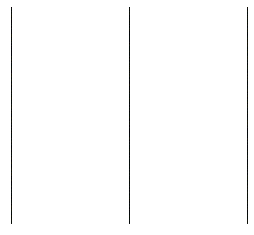

block5_conv2
512


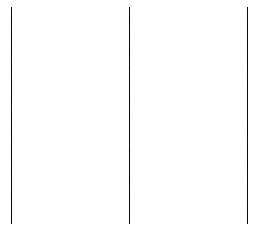

block5_conv3
512


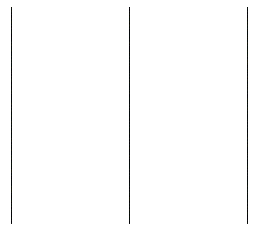

In [18]:
# Iterate thru all the layers of the model

for layer in base_model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        # filters, biases = layer.get_weights()
        print(layer.name)
        # print(layer.name, filters.shape)
        # normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        # plotting all the filters
        for i in range(filters.shape[3]):
            # get the filters
            filt=filters[:,:,:, i]
            # plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

(1, 180, 180, 64)
(1, 180, 180, 64)
(1, 90, 90, 64)
(1, 90, 90, 128)
(1, 90, 90, 128)
(1, 45, 45, 128)
(1, 45, 45, 256)
(1, 45, 45, 256)
(1, 45, 45, 256)
(1, 22, 22, 256)
(1, 22, 22, 512)
(1, 22, 22, 512)
(1, 22, 22, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 5, 5, 512)


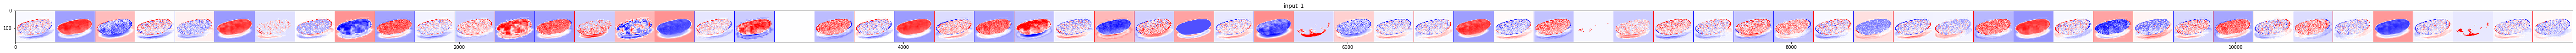

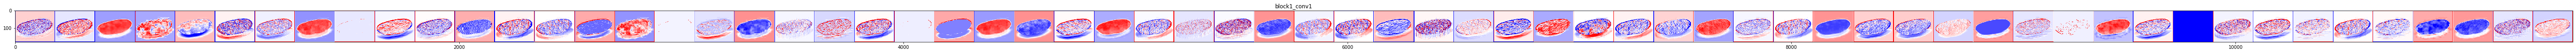

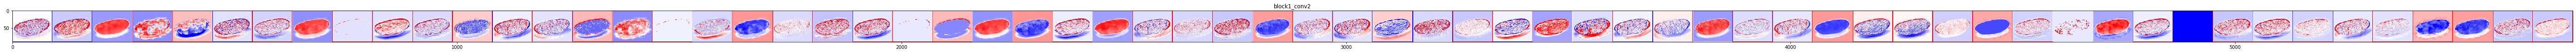

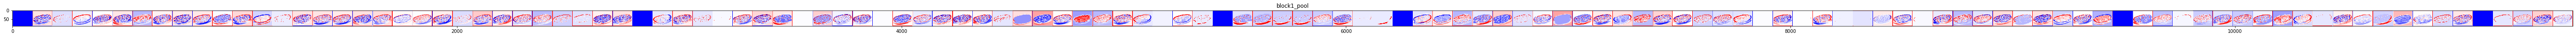

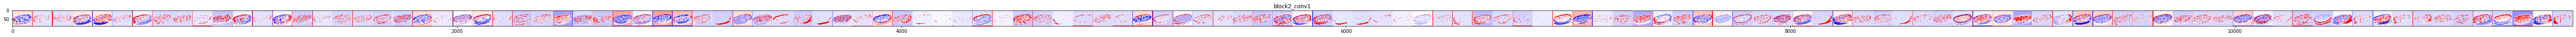

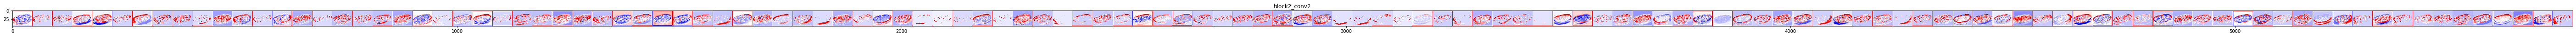

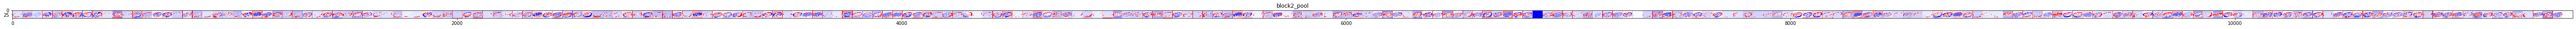

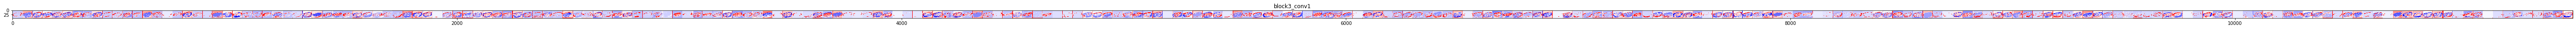

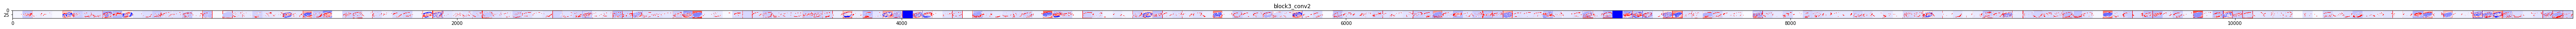

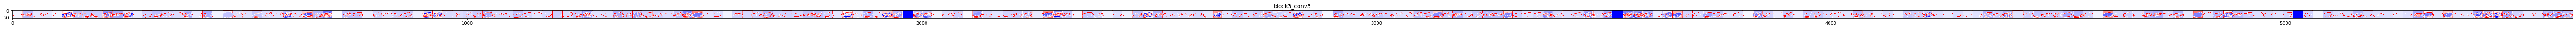

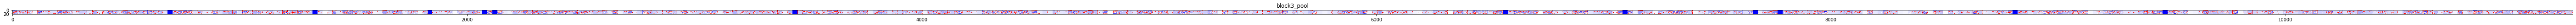

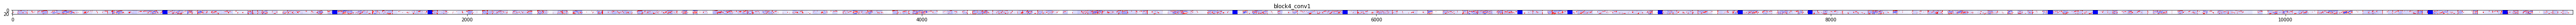

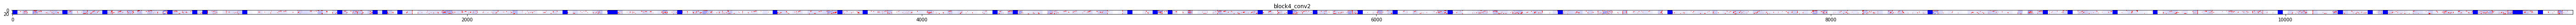

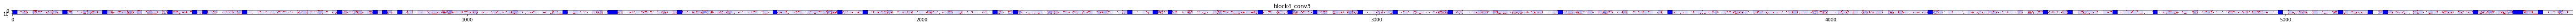

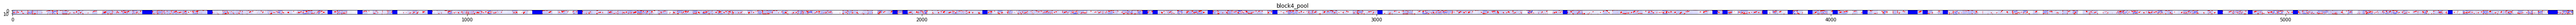

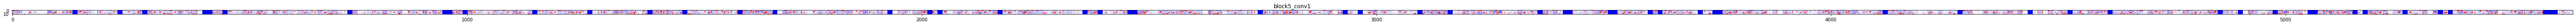

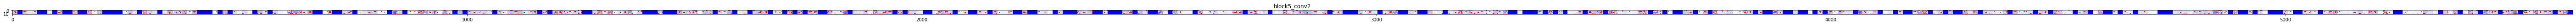

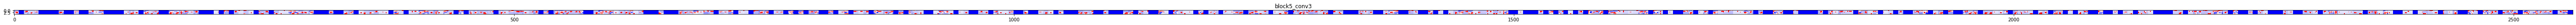

In [127]:
# Visualize feature maps for an organic image

# Image path
img_path=test_dir + '/O' + '/O_12825.jpg'

# Define a new model, input=image 
# Output=intermediate representations for all layers in the previous model after the first
successive_outputs = [layer.output for layer in base_model.layers[1:]]

# Visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = base_model.input, outputs = successive_outputs)

# Load the input image
img = load_img(img_path, target_size=(180, 180))

# Convert ht image to Array of dimension (180,180,3)
x = img_to_array(img)                           
x = x.reshape((1,) + x.shape)

# Rescale by 1/255
x /= 255.0

# Run input image through our visualization network to obtain all intermediate representations for the image
successive_feature_maps = visualization_model.predict(x)

# Retrieve the names of the layers, so we can have them as part of our plot
layer_names = [layer.name for layer in base_model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile our images in a matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
        
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
        
# Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features*5, scale*4))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='bwr' )

# Disable tf warning
logging.getLogger('tensorflow').disabled = True

(1, 180, 180, 64)
(1, 180, 180, 64)
(1, 90, 90, 64)
(1, 90, 90, 128)
(1, 90, 90, 128)
(1, 45, 45, 128)
(1, 45, 45, 256)
(1, 45, 45, 256)
(1, 45, 45, 256)
(1, 22, 22, 256)
(1, 22, 22, 512)
(1, 22, 22, 512)
(1, 22, 22, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 11, 11, 512)
(1, 5, 5, 512)


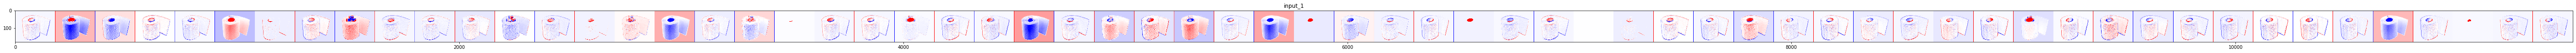

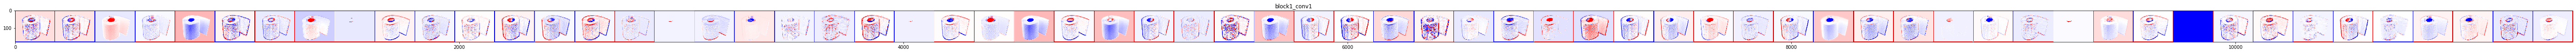

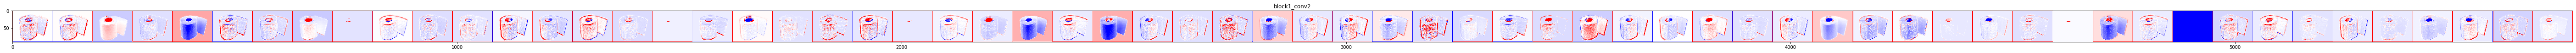

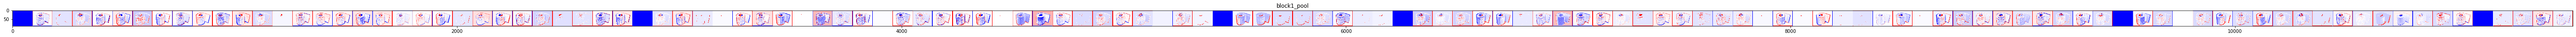

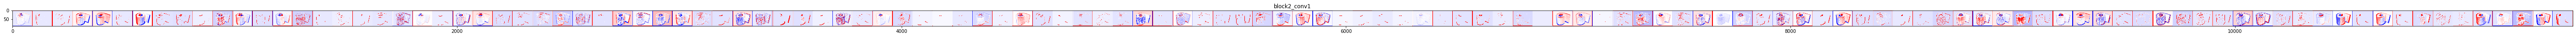

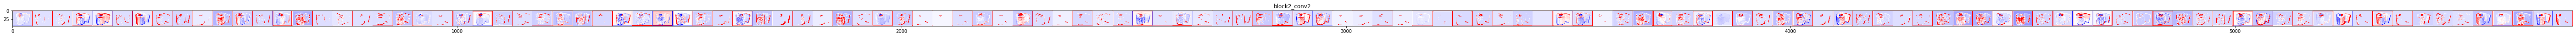

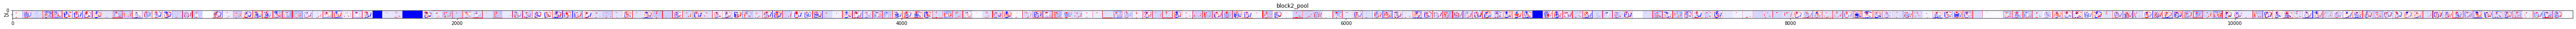

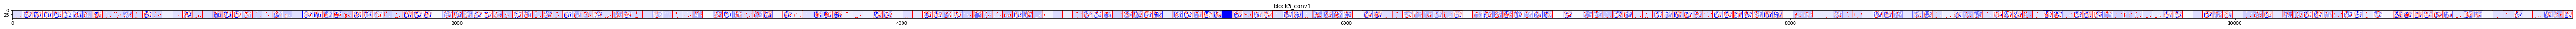

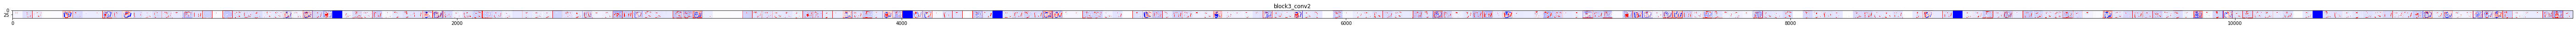

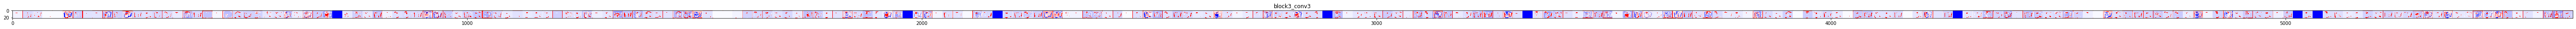

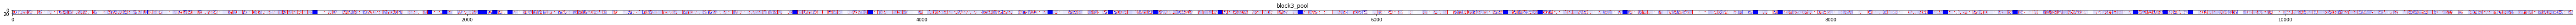

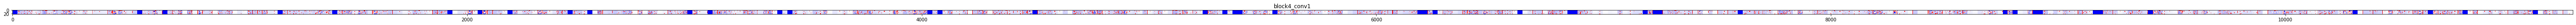

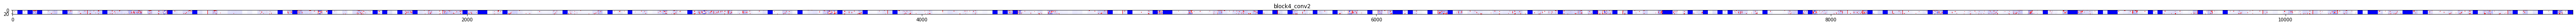

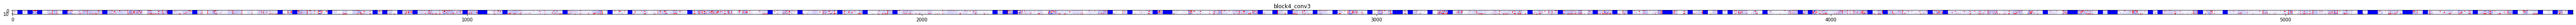

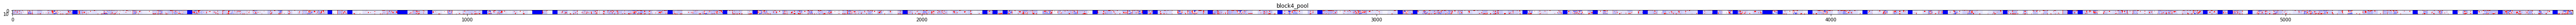

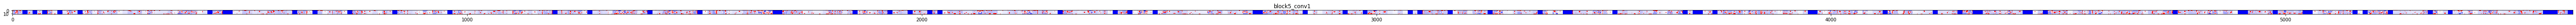

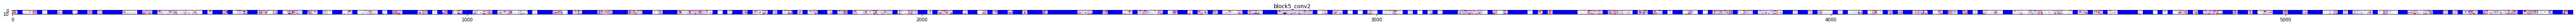

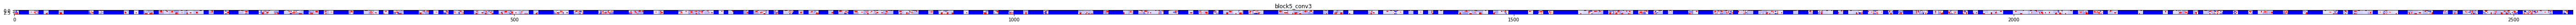

In [126]:
# Visualize feature maps for a recycled image

# Image path
img_path=test_dir + '/R' + '/R_11107.jpg'

# Define a new model, input=image 
# Output=intermediate representations for all layers in the previous model after the first
successive_outputs = [layer.output for layer in base_model.layers[1:]]

# Visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = base_model.input, outputs = successive_outputs)

# Load the input image
img = load_img(img_path, target_size=(180, 180))

# Convert ht image to Array of dimension (180,180,3)
x = img_to_array(img)                           
x = x.reshape((1,) + x.shape)

# Rescale by 1/255
x /= 255.0

# Run input image through our visualization network to obtain all intermediate representations for the image
successive_feature_maps = visualization_model.predict(x)

# Retrieve the names of the layers, so we can have them as part of our plot
layer_names = [layer.name for layer in base_model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers

    n_features = feature_map.shape[-1]  # number of features in the feature map
    size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
        
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
        
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features*5, scale*4) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='bwr' )

# Ignore Runtimewarning
warnings.filterwarnings('ignore')

## Adding to the Base Model -  Building Dense Layers

In [22]:
# Defining Layers
model=Sequential()
model.add(base_model) 
model.add(Dropout(0.2))
model.add(Flatten())

# Add dense layers
model.add(BatchNormalization())
# model.add(Dense(5000,activation="relu",kernel_initializer='he_uniform'))
model.add(Dense(256,activation="relu",kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# model.add(Dense(1000,activation="relu",kernel_initializer='he_uniform'))
model.add(Dense(128,activation="relu",kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# model.add(Dense(500,activation="relu",kernel_initializer='he_uniform'))
model.add(Dense(64,activation="relu",kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))

In [23]:
# Show model summary (with custom layers)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12800)             51200     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               3277056   
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

## Model Training

In [24]:
# Model fit (training)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC(name = 'auc')])
model_history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks = callback_list, verbose = 1)

2023-03-18 20:27:26.677457: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
565/565 [==============================] - 2245s 4s/step - loss: 0.5144 - auc: 0.8634 - val_loss: 0.3083 - val_auc: 0.9439

Epoch 00001: val_auc improved from -inf to 0.94393, saving model to final_model


2023-03-18 21:04:54.727670: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: final_model/assets
Epoch 2/20
565/565 [==============================] - 3505s 6s/step - loss: 0.3332 - auc: 0.9335 - val_loss: 0.3113 - val_auc: 0.9440

Epoch 00002: val_auc improved from 0.94393 to 0.94403, saving model to final_model
INFO:tensorflow:Assets written to: final_model/assets
Epoch 3/20
565/565 [==============================] - 5112s 9s/step - loss: 0.3002 - auc: 0.9450 - val_loss: 0.2988 - val_auc: 0.9474

Epoch 00003: val_auc improved from 0.94403 to 0.94744, saving model to final_model
INFO:tensorflow:Assets written to: final_model/assets
Epoch 4/20
565/565 [==============================] - 4615s 8s/step - loss: 0.2922 - auc: 0.9479 - val_loss: 0.3280 - val_auc: 0.9342

Epoch 00004: val_auc did not improve from 0.94744
Epoch 5/20
565/565 [==============================] - 2436s 4s/step - loss: 0.2739 - auc: 0.9544 - val_loss: 0.2825 - val_auc: 0.9531

Epoch 00005: val_auc improved from 0.94744 to 0.95312, saving model to final_model

In [25]:
# Storing loss and accuracy values into a DataFrame to save permanently for plots

# Store model.fit results in a variable
history = model_history

# Save as DataFrame:     
history_df = pd.DataFrame(history.history) 
history_df

loss       auc  val_loss   val_auc
0  0.425145  0.897887  0.308286  0.943931
1  0.320669  0.937905  0.311300  0.944031
2  0.297400  0.946078  0.298794  0.947439
3  0.291707  0.948250  0.327991  0.934237
4  0.277117  0.953237  0.282493  0.953123
5  0.269961  0.955607  0.292653  0.951315
6  0.261888  0.958179  0.288035  0.951409
7  0.255684  0.959905  0.303551  0.947413
8  0.254597  0.960282  0.304965  0.946672
9  0.243623  0.963589  0.301743  0.948844

In [26]:
# Save as csv
history_df.to_csv('Resources/Model/model_history.csv', index=False)

In [27]:
# Import csv
model_history = pd.read_csv('Resources/Model/model_history.csv')
model_history 

loss       auc  val_loss   val_auc
0  0.425145  0.897887  0.308286  0.943931
1  0.320669  0.937905  0.311300  0.944031
2  0.297400  0.946078  0.298794  0.947439
3  0.291707  0.948250  0.327991  0.934237
4  0.277117  0.953237  0.282493  0.953123
5  0.269961  0.955607  0.292653  0.951315
6  0.261888  0.958179  0.288035  0.951409
7  0.255684  0.959905  0.303551  0.947413
8  0.254597  0.960282  0.304965  0.946672
9  0.243623  0.963589  0.301743  0.948844

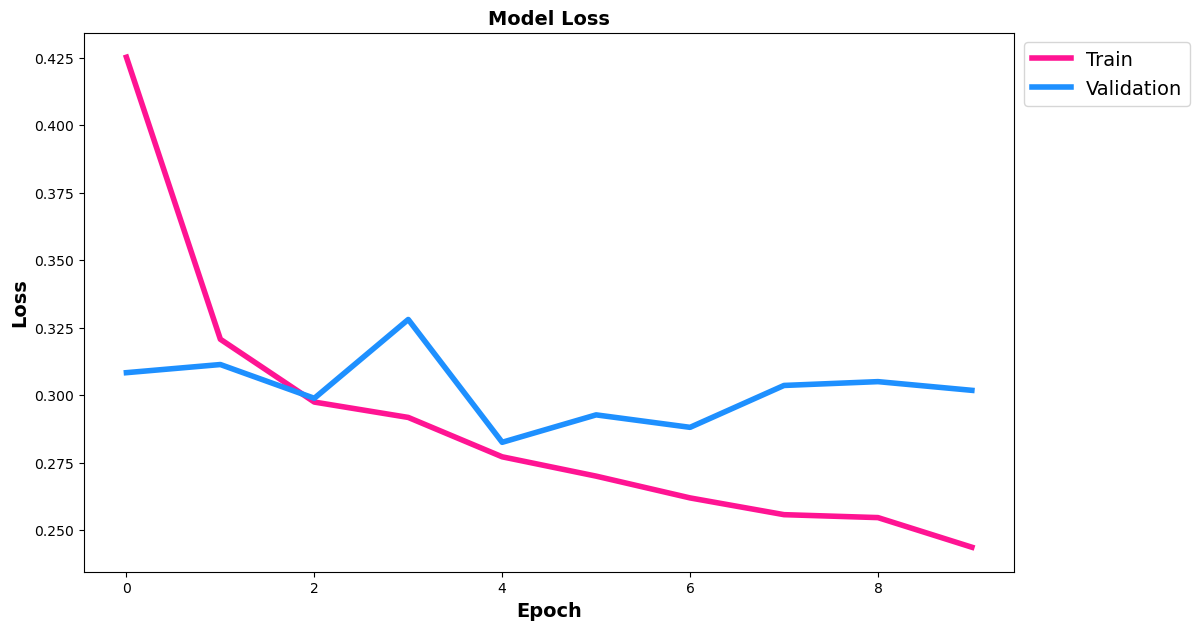

In [28]:
# Plot model loss

plt.figure(figsize=(12,7))
plt.plot(model_history['loss'], color='deeppink', linewidth=4)
plt.plot(model_history['val_loss'], color='dodgerblue', linewidth=4)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1), fontsize=14)
plt.show()

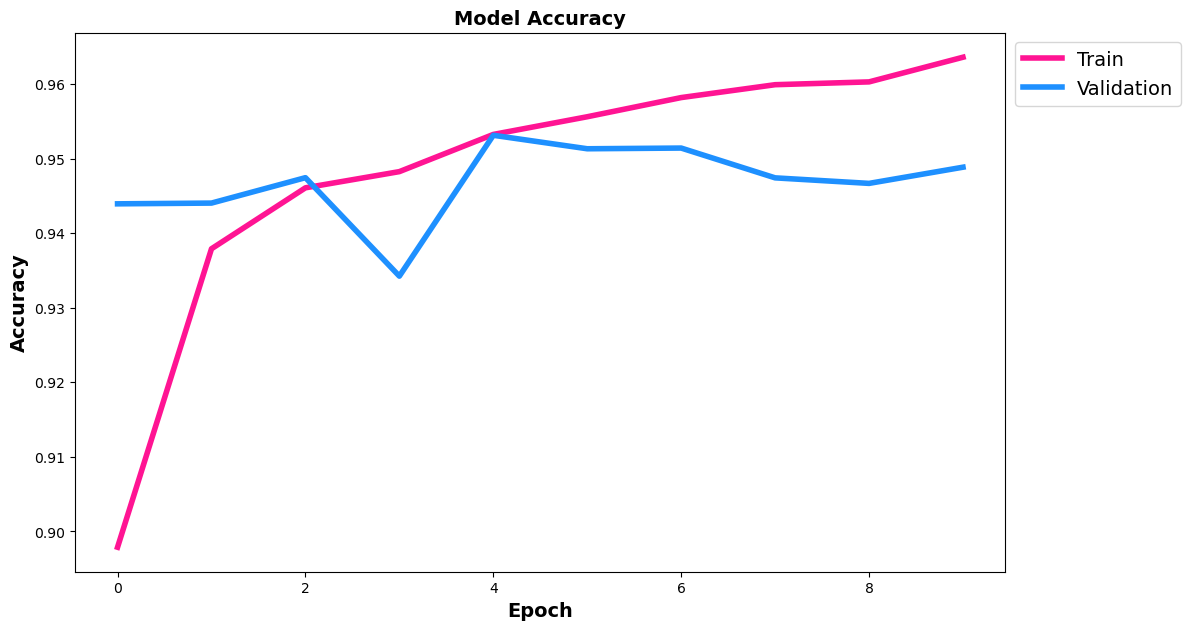

In [29]:
# Plot the model accuracy

plt.figure(figsize=(12,7))
plt.plot(model_history['auc'], color='deeppink', linewidth=4)
plt.plot(model_history['val_auc'], color='dodgerblue', linewidth=4)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1), fontsize=14)
plt.show()

## Model Evaluation

In [30]:
# Evaluate overall loss and accuracy for test data
model.evaluate(test_ds)

79/79 [==============================] - 212s 3s/step - loss: 0.3742 - auc: 0.9297


[0.3742147386074066, 0.9297094345092773]

In [31]:
# Store final values as variables

# loss_final = 0.3659922480583191
# auc_final = 0.9392455220222473
loss_final = 0.3742147386074066
auc_final = 0.9297094345092773
print(f"The final loss was {loss_final}, and the final accuracy was {auc_final}.")

The final loss was 0.3742147386074066, and the final accuracy was 0.9297094345092773.


## Classification Report

In [32]:
# Confusion Matrix and Classification Report

metrics=tf.keras.metrics.AUC(name = 'auc')

num_of_test_samples = 2513
batch_size = 32

Y_pred = model.predict(test_ds, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))
print('Classification Report')
target_names = ['Organic', 'Recycled']
print(classification_report(test_ds.classes, y_pred, target_names=target_names))

Confusion Matrix
[[1292  109]
 [ 230  882]]
Classification Report
              precision    recall  f1-score   support

     Organic       0.85      0.92      0.88      1401
    Recycled       0.89      0.79      0.84      1112

    accuracy                           0.87      2513
   macro avg       0.87      0.86      0.86      2513
weighted avg       0.87      0.87      0.86      2513



Text(0.5, 1.0, 'Classification Report')

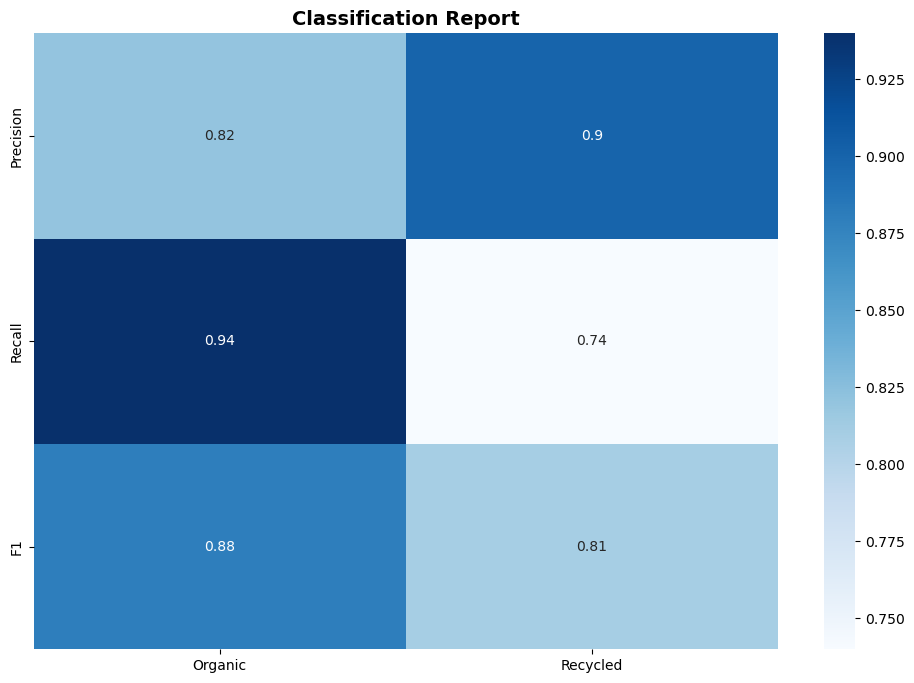

In [33]:
# Plot the classification report

# Put data into a 2D array
data = np.array([[.82, .90],
                 [.94, .74],
                [.88, .81]])

# Plot the heatmap
yticklabels = ['Precision', 'Recall', 'F1']
xticklabels = ['Organic', 'Recycled']
fig, ax = plt.subplots(figsize=(12,8)) 
ax = sns.heatmap(data, xticklabels=xticklabels, yticklabels=yticklabels, annot=True, cmap='Blues')
ax.set_title("Classification Report", fontsize=14, fontweight='bold')

## True & False Positives

In [ ]:
# Removing scientific notation in the heatmap

np.set_printoptions(suppress=True, threshold=2000)

Text(79.5, 0.5, 'Predicted')

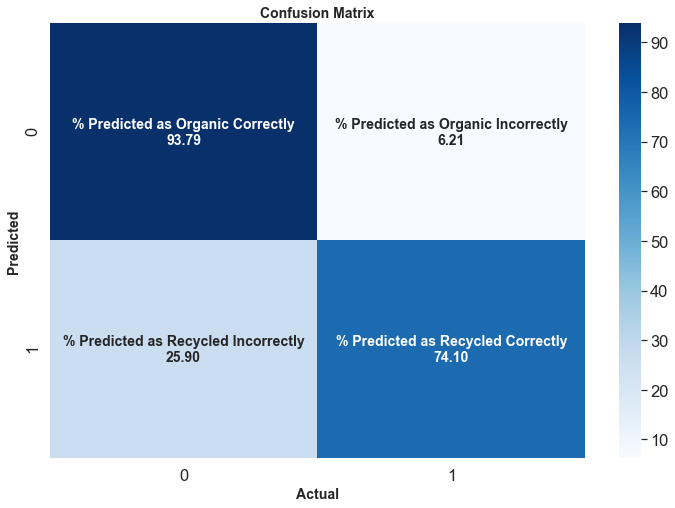

In [286]:
# Confusion matrix plot

# Converting integers to percents
perc1 = round(1314/1401*100,2)
perc2 = round(87/1401*100,2)
perc3 = round(288/1112*100,2)
perc4 = round(824/1112*100,2)

# Put data into a 2D array
data = np.array([[perc1, perc2],
                [perc3, perc4]])

text = np.array([['% Predicted as Organic Correctly', '% Predicted as Organic Incorrectly'], 
                ['% Predicted as Recycled Incorrectly', '% Predicted as Recycled Correctly']]) 

# Combine text with values 
formatted_text = (np.asarray(["{0}\n{1:.2f}".format( 
text, data) for text, data in zip(text.flatten(), data.flatten())])).reshape(2, 2) 

# Plot heatmap  
fig, ax = plt.subplots(figsize=(12,8)) 
sns.set(font_scale=1.5)
ax = sns.heatmap(data_percent, annot=formatted_text, fmt="", cmap='Blues', annot_kws={"fontsize":14, "weight":'bold'})
ax.set_title("Confusion Matrix", fontsize=14, fontweight='bold')
ax.set_xlabel("Actual", fontsize=14, fontweight='bold')
ax.set_ylabel("Predicted", fontsize=14, fontweight='bold')

## Predicting Test Images

In [34]:
# Load the saved model weights

# model = load_model('Resources/Model/final_model_weights.hdf5')
model_path = "./final_model/"
model = load_model(model_path)

In [35]:
def getprediction(img):
    img = img_to_array(img)
    img = img / 255
    imshow(img)
    plt.axis('off')
    img = np.expand_dims(img,axis=0)
    category = model.predict_classes(img)
    answer = category[0]
    probability = model.predict_proba(img)
    # probability_results = probability[0][0]
    if answer == 1:
        print(f"The image belongs to Recycle waste category, probability: {probability[0][1]}.")
    else:
        print(f"The image belongs to Organic waste category, probability: {probability[0][0]}.")

The image belongs to Organic waste category, probability: 0.9918318390846252.


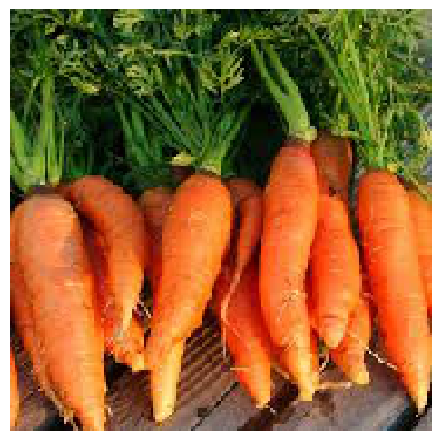

In [38]:
# Test Case 1 - ORGANIC

test_case1 = load_img(test_dir + '/O' + '/O_12568.jpg', target_size=(180,180))
getprediction(test_case1)

The image belongs to Organic waste category, probability: 0.9998617172241211.


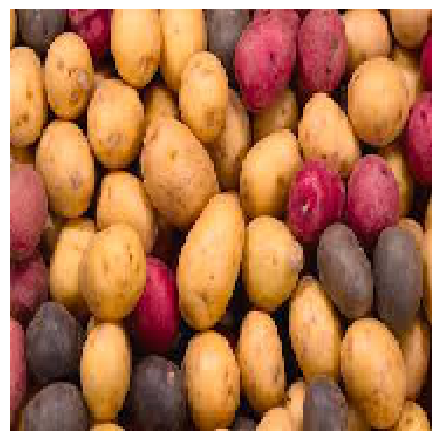

In [39]:
# Test Case 2 - ORGANIC

test_case2 = load_img(test_dir + '/O' + '/O_13185.jpg', target_size=(180,180))
getprediction(test_case2)

The image belongs to Organic waste category, probability: 0.9840987324714661.


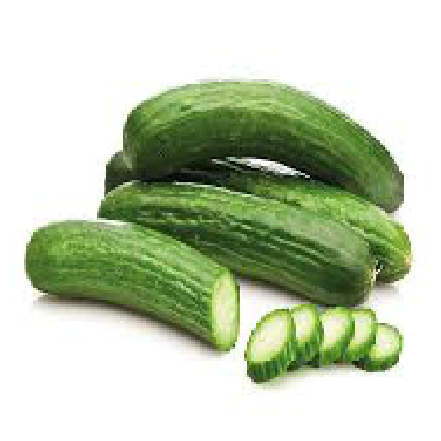

In [40]:
# Test Case 3 - ORGANIC

test_case3 = load_img(test_dir + '/O' + '/O_13905.jpg', target_size=(180,180))
getprediction(test_case3)

The image belongs to Recycle waste category, probability: 0.8865536451339722.


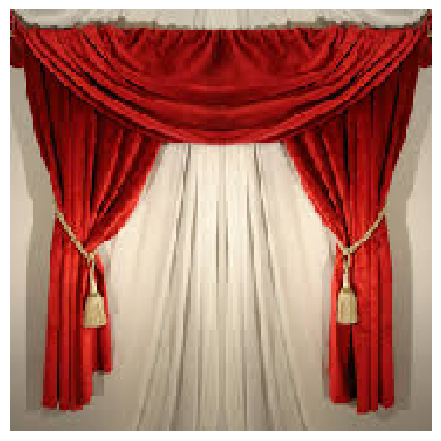

In [41]:
# Test Case 4 - RECYCLED

test_case4 = load_img(test_dir + '/R' + '/R_10000.jpg', target_size=(180,180))
getprediction(test_case4)

The image belongs to Recycle waste category, probability: 0.7618786096572876.


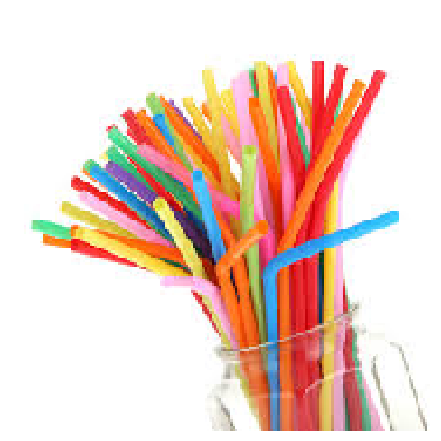

In [42]:
# Test Case 5 - RECYCLED

test_case5 = load_img(test_dir + '/R' + '/R_10398.jpg', target_size=(180,180))
getprediction(test_case5)

The image belongs to Recycle waste category, probability: 0.9529083967208862.


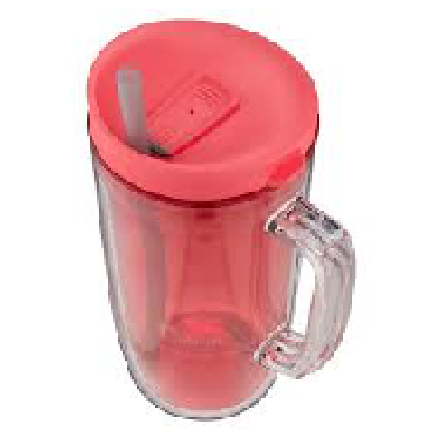

In [43]:
# Test Case 6 - RECYCLED
test_case6 = load_img(test_dir + '/R' + '/R_10714.jpg', target_size=(180,180))
getprediction(test_case6)

The image belongs to Recycle waste category, probability: 0.9210506677627563.


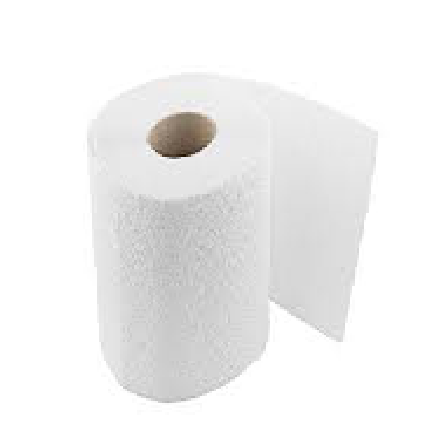

In [44]:
# Test Case 7 - RECYCLED
test_case7 = load_img(test_dir + '/R' + '/R_11107.jpg', target_size=(180,180))
getprediction(test_case7)

The image belongs to Recycle waste category, probability: 0.6966738700866699.


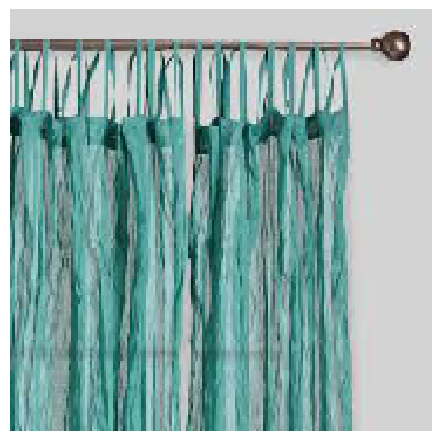

In [45]:
# Test Case 8 - RECYCLED
test_case8 = load_img(test_dir + '/R' + '/R_10005.jpg', target_size=(180,180))
getprediction(test_case8)